# Baseline LSTM Model using GloVe Embeddings

In [1]:
import sys,os, re, csv, codecs
import numpy as np
import pandas as pd
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers,layers
from keras.callbacks import EarlyStopping
from time import time

Using TensorFlow backend.


## Importing Data and Embeddings

Embedding File : Wikipedia GloVe dataset with 200-Dimensional representation -> embed_size

Maximum number of unique words to use: 20000 -> max_features

Maximum number of words to use in a comment: 100 -> maxlen

In [2]:
#training and testing files with the data augmentation sets 
train_file_en= '../input/jigsaw-toxic-comment-classification-challenge/train.csv'
train_file_de= '../input/toxic-comments-french-spanish-german-train/train_de.csv'
train_file_fr= '../input/toxic-comments-french-spanish-german-train/train_fr.csv'
train_file_es= '../input/toxic-comments-french-spanish-german-train/train_es.csv'

test_file= '../input/jigsaw-toxic-comment-classification-challenge/test.csv'
test_label_file = '../input/jigsaw'

#Using the GloVe embedding file
embedding_file = '../input/glove6b200d/glove.6B.200d.txt'

train_en = pd.read_csv(train_file_en)
train_es = pd.read_csv(train_file_es)
train_fr = pd.read_csv(train_file_fr)
train_de = pd.read_csv(train_file_de)

#Augmented Dataset
train = train_en.append(train_es.append(train_de, ignore_index=True), ignore_index=True)
test = pd.read_csv(test_file)

#Only English
train1 = train_en

In [3]:
embed_size = 200 #Embedding dimension
max_features = 200000 #Maximum number of words to keep based on frequency
maxlen = 100 #Maximum Length of comments

In [4]:
#Extracting the comments and removing the Empty comments
list_sentences_train = train["comment_text"].fillna("_na_").values
list_sentences_train1 = train1["comment_text"].fillna("_na_").values

list_sentences_test = test["comment_text"].fillna("_na_").values

#Categories
list_classes = ["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Category Tags
y_t = train[list_classes].values
y_t1 = train1[list_classes].values

np.shape(y_t1)

#Storing the sentences as a list
X_train = train["comment_text"].str.lower()
y_train = train[list_classes].values
X_test = test["comment_text"].str.lower()

#List of comments
X_train = list(X_train)
X_test = list(X_test)

In [5]:
X_train[1]

"d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)"

# Preparing the Text Data

## Data Cleanup

On noticing the above data we can see that the text data needs cleaning. The various cleanup steps applied are:

   * Noise Removal, wherein we remove the unnecessary whitespaces and numerals from the text
   * Replace certain commonly used phrases and symbols with words that closely resemble them
    Adjust text such as www as https which dont mean anything.


In [6]:
#Removes unwanted symbols and whitespace from the text
def remove_noise(input_text):
    text = re.sub('[\\t\\n\\r\\f\\v]','',input_text) #Removes unnecessary whitespaces
    #text = re.sub(r'[^\w\s]','',text) #Removes all special characters like colons
    text = text.split()
    text = [re.sub('[\d]+','',x) for x in text] #Removes numbers
    return ' '.join(text) #Joins it back

#Apply it to training and testing set
for i in range(len(X_train)):
    X_train[i] = remove_noise(X_train[i])
for i in range(len(X_test)):
    X_test[i] = remove_noise(X_test[i])

In [7]:
X_train[1] #Clean Text

"d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) :, january ,  (utc)"

In [8]:
#Replace some of the commonly occuring phrases and emojis with standard text 
#Text is closest in meaning to the emotion being expressed by the phrase or emoji

def replace_word(X):
    repl = {
        "im" : " I am","&lt;3": " good ",":d": " good ",":dd": " good ",":p": " good ","8)": " good ",":-)": " good ", ":)": " good ",";)": " good ",
        "(-:": " good ","(:": " good ","yay!": " good ","yay": " good ","yaay": " good ","yaaay": " good ","yaaaay": " good ",
        "yaaaaay": " good ",":/": " bad ",":&gt;": " sad ",":')": " sad ",":-(": " bad ",":(": " bad ", ":s": " bad ",":-s": " bad ",
        "&lt;3": " heart ",":d": " smile ",":p": " smile ",":dd": " smile ","8)": " smile ", ":-)": " smile ", ":)": " smile ",
        ";)": " smile ","(-:": " smile ","(:": " smile ",":/": " worry ",":&gt;": " angry ", ":')": " sad ",":-(": " sad ",":(": " sad ",
        ":s": " sad ", ":-s": " sad ",r"\br\b": "are",r"\bu\b": "you",r"\bhaha\b": "ha",r"\bhahaha\b": "ha",r"\bdon't\b": "do not",
        r"\bdoesn't\b": "does not",r"\bdidn't\b": "did not",r"\bhasn't\b": "has not",r"\bhaven't\b": "have not",r"\bhadn't\b": "had not",
        r"\bwon't\b": "will not",r"\bwouldn't\b": "would not",r"\bcan't\b": "can not",r"\bcannot\b": "can not",r"\bi'm\b": "i am",
        "m": "am","r": "are","u": "you","haha": "ha","hahaha": "ha","don't": "do not","doesn't": "does not","didn't": "did not",
        "hasn't": "has not","haven't": "have not","hadn't": "had not","won't": "will not","wouldn't": "would not","can't": "can not",
        "cannot": "can not","i'm": "i am","m": "am","i'll" : "i will","its" : "it is","it's" : "it is","'s" : " is","that's" : "that is",
        "weren't" : "were not"
    }
    keys = repl.keys()
    new_X = []
    for i in X:
        arr = str(i).split()
        xx = ""
        for j in arr:
            j = str(j).lower()
            if j[:4] == 'http' or j[:3] == 'www':
                continue
            if j in keys:
                j = repl[j]
            xx += j + " "
        new_X.append(xx)
    return new_X

X_train = replace_word(X_train)
X_test = replace_word(X_test)

In [9]:
X_train[1]

"d'aww! he matches this background colour i am seemingly stuck with. thanks. (talk) :, january , (utc) "

In [10]:
#Using Keras' Tokenizer function on augmented dataset
#Vectorize a text corpus, by turning each text into either a sequence of integers 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train)+list(X_test)) 

#Takes the 200000 max frequency words in the dataset and creates tokens out of them
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_train)


X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

#Word Index holds the index integer values for all the words based on the Tokenizer aas a dictionary
word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 464631 unique tokens.


In [11]:
#Word Index Dictionary where each 
#word_index

In [12]:
#Every comment in the dataset is now a sequence of integers of equal length
list_tokenized_train[0]

[119193,
 1,
 205,
 130,
 192,
 30,
 625,
 4293,
 10632,
 1025,
 79,
 587,
 46,
 79,
 11,
 17940,
 53,
 6322,
 15,
 64,
 2549,
 139,
 5,
 2801,
 41,
 112,
 1131,
 9356,
 2579,
 4,
 55,
 20,
 11,
 257,
 1,
 353,
 33,
 1,
 52,
 31,
 122,
 5,
 39,
 3513,
 88]

In [13]:
#Using Keras' Tokenizer function on English dataset
tokenizer1 = Tokenizer(num_words=max_features)
tokenizer1.fit_on_texts(list(list_sentences_train1))

list_tokenized_train1 = tokenizer1.texts_to_sequences(list_sentences_train1)
list_tokenized_test1 = tokenizer1.texts_to_sequences(list_sentences_test)

X_t1 = pad_sequences(list_tokenized_train1, maxlen=maxlen)
X_te1 = pad_sequences(list_tokenized_test1, maxlen=maxlen)

word_index1 = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index1))
np.shape(X_t1)

Found 464631 unique tokens.


(159571, 100)

In [14]:
#Every comment is a sequence of indices
list_tokenized_train1[0]

[688,
 75,
 1,
 126,
 130,
 177,
 29,
 672,
 4511,
 12052,
 1116,
 86,
 331,
 51,
 2278,
 11448,
 50,
 6864,
 15,
 60,
 2756,
 148,
 7,
 2937,
 34,
 117,
 1221,
 15190,
 2825,
 4,
 45,
 59,
 244,
 1,
 365,
 31,
 1,
 38,
 27,
 143,
 73,
 3462,
 89,
 3085,
 4583,
 2273,
 985]

# GloVe Word Embeddings

We will be using GloVe embeddings, which you can read about here. GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics.

Specifically, we will use the **200-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia.** 

## Preparing Embedding Layer

Returns a 20-dimensional vector space coordinate for each word in the embedding, i.e. 400k words each have a 200-d representation.

In [15]:
#Dictionary of word and their embedding values
#There are embeddings for 400k words and each embedding is a 200-d vector
embeddings_index={}

f = open(embedding_file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 400000 word vectors.


## Preparing Embedding Matrix

Words that are not in GloVe are randomly initialized
Creating an embedding matrix for 20000 words where each word has a 200 dimensional representation.

In [16]:
#Embedding matrix for 400k words
all_embeddings = np.stack(embeddings_index.values())

emb_mean= all_embeddings.mean()
emb_stddev = all_embeddings.std()

np.shape(all_embeddings)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


(400000, 200)

In [17]:
#Embedding Matrix for Augmented Dataset
#Number of words is assigned as the minimum of either 400
nb_words = min(max_features, len(word_index)+1)

#Creating a matrix of length of the number of words we choose to represent
embedding_matrix = np.random.normal(emb_mean, emb_stddev, (nb_words, embed_size))

#For augmented data
for word, i in word_index.items():
    if i>=max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

np.shape(embedding_matrix)

(200000, 200)

In [18]:
#Creating a matrix of length of the number of words we choose to represent
embedding_matrix1 = np.random.normal(emb_mean, emb_stddev, (nb_words, embed_size))

#For augmented data
for word, i in word_index1.items():
    if i>=max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector

np.shape(embedding_matrix1)

(200000, 200)

In [19]:
#Embedding Matrix for Augmented Dataset

nb_words = min(max_features, len(word_index1)+1)
embedding_matrix1 = np.random.normal(emb_mean, emb_stddev, (nb_words, embed_size))
for word, i in word_index1.items():
    if i>=max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector

np.shape(embedding_matrix)

(200000, 200)

## Model

Simple bidirectional LSTM with two fully connected layers and adding some dropout is necessary.

In [20]:
#Early Stopping 

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [21]:
#Model with Data Augmentation 

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
#Model without Data Augmentation 

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix1])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [23]:
#Model fitting with Augmented Data
history = model.fit(X_t, y_t, batch_size=256, epochs=5, validation_split=0.2,callbacks=[es]);

Train on 382970 samples, validate on 95743 samples
Epoch 1/5
382970/382970 [==============================] - 832s 2ms/step - loss: 0.0638 - acc: 0.9785 - val_loss: 0.0464 - val_acc: 0.9827
Epoch 2/5
382970/382970 [==============================] - 828s 2ms/step - loss: 0.0406 - acc: 0.9844 - val_loss: 0.0394 - val_acc: 0.9850
Epoch 3/5
382970/382970 [==============================] - 835s 2ms/step - loss: 0.0320 - acc: 0.9875 - val_loss: 0.0355 - val_acc: 0.9865
Epoch 4/5
382970/382970 [==============================] - 836s 2ms/step - loss: 0.0262 - acc: 0.9898 - val_loss: 0.0332 - val_acc: 0.9879
Epoch 5/5
382970/382970 [==============================] - 833s 2ms/step - loss: 0.0210 - acc: 0.9919 - val_loss: 0.0312 - val_acc: 0.9892


In [24]:
#Model fitting without Augmented Data
history1 = model1.fit(X_t1, y_t1, batch_size=256, epochs=5, validation_split=0.2,callbacks=[es]);

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 288s 2ms/step - loss: 0.1078 - acc: 0.9675 - val_loss: 0.0537 - val_acc: 0.9810
Epoch 2/5
127656/127656 [==============================] - 285s 2ms/step - loss: 0.0498 - acc: 0.9821 - val_loss: 0.0494 - val_acc: 0.9817
Epoch 3/5
127656/127656 [==============================] - 284s 2ms/step - loss: 0.0420 - acc: 0.9843 - val_loss: 0.0485 - val_acc: 0.9820
Epoch 4/5
127656/127656 [==============================] - 283s 2ms/step - loss: 0.0356 - acc: 0.9862 - val_loss: 0.0512 - val_acc: 0.9822


In [25]:
y_test = model.predict([X_te],batch_size = 1024, verbose=1)
y_test1 = model1.predict([X_te],batch_size = 1024, verbose=1)


'''
sample_submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv',index = False)
'''

478713/478713 [==============================] - 90s 188us/step


"\nsample_submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')\nsample_submission[list_classes] = y_test\nsample_submission.to_csv('submission.csv',index = False)\n"

In [29]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 200)          40000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          100400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

In [27]:
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 200)          40000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          100400    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total para

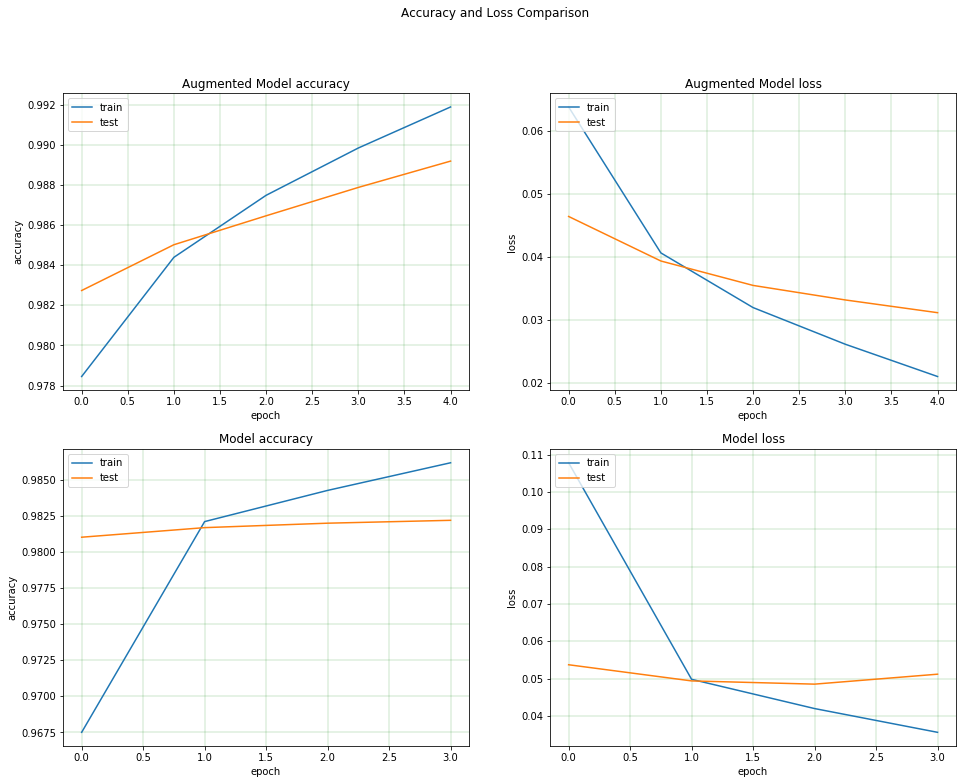

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#print(history.history.keys())


plt.figure(figsize=(16,12))
plt.suptitle('Accuracy and Loss Comparison')

gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Augmented Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(color='g', linewidth = 0.2)
plt.legend(['train','test'],loc='upper left')


plt.subplot2grid((2,2),(0,1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Augmented Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(color='g', linewidth = 0.2)
plt.legend(['train','test'],loc='upper left')

plt.subplot2grid((2,2),(1,0))
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(color='g', linewidth = 0.2)
plt.legend(['train','test'],loc='upper left')


plt.subplot2grid((2,2),(1,1))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(color='g', linewidth = 0.2)
plt.legend(['train','test'],loc='upper left')

plt.show()

We can see that the Augmented dataset helps in training the model better, whereas the model with no data augmentation leads to overfitting.

Moreover, the augmented data model achieves a validation accuracy of **98.92%** compared to 98.22% of the non-augmented model. The model using non-augmente data also never really improves its performance considering the stagnation of the validation accuracy